# Getting Benchmark models from Keras

This notebook contains the code in which I used to get my benchmarks models to compare their initial accuracy.  
I did this by comparing their validation accuracy after 40 epochs with the same top layers.  
This was to see which pre-trained model arcitecture was best suited for this pose classification challenge.  

**Note: Set your google colab runtime type to GPU(You can thank me later :p)**
 
 Side note: This is the notebook I (mostly) used when first trying to get a benchmark on which architecture/model would perform the best for this challenge. (My original code was much more messy)  
 
 If you are looking for the object detection notebook or what the team did for the final model, please look for those notebooks respectively.

---

# Setting up the notebook

Setting up the main directories and importing the libraries.  

Also setting up the images used to train the models.

To link google drive with dataset to google colab.  
For anyone else following along in the code, you have to somehow upload or link your own dataset into the google colab. (Just Google around)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Importing modules that we are using later on, (Not really sure if all was used, but I'm to lazy to check. Since this takes less than 10 seconds, it should not affect the speed of the notebook in any impactful way)

In [0]:
# numpy
import numpy as np
# matplotlib
import matplotlib.pyplot as plt
# scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# keras
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping


Setting up the directories to the dataset in colab.  
For anyone with different directories in colab, you **will have to change this according to your colab files**

In [0]:
import os

# Base directory has to be changed here
base_dir = 'gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset'

# Directory to our training data
train_folder = os.path.join(base_dir, 'train')

# Directory to our validation data
val_folder = os.path.join(base_dir, 'val')


# List folders and number of files
print("Directory, Number of files")
for root, subdirs, files in os.walk(base_dir):
    print(root, len(files))

Directory, Number of files
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset 0
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val 0
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/EaglePose 27
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/ChestBump 17
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/ChildPose 22
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/Dabbing 23
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/ChairPose 23
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/Spiderman 26
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/HandGun 26
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/WarriorPose 22
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/KungfuSalute 25
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/Salute 24
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/KoreanHeart 22
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/KungfuCrane 21
gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/val/HulkSmash 24
gdrive/

We will be setting up the image generators that will be feeding the training and validation dataset for the model later on.   

 Things to take note of here (I had to spend alot of time here as I did not understand what the parameters being passed to the function were):
 

*   Batch size (bs)
*   image_size
*   params for the ImageDataGenerator



In [0]:
# Batch size
bs = 32

# All images will be resized to this value
image_size = (299, 299)

# All images will be rescaled by 1./255. We apply data augmentation here.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   brightness_range= [0.5,1.5],
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
print("Preparing generator for train dataset")
train_generator = train_datagen.flow_from_directory(
    directory= train_folder, # This is the source directory for training images 
    target_size=image_size, # All images will be resized to value set in image_size
    batch_size=bs,
    class_mode='categorical')

# Flow validation images in batches of 32 using val_datagen generator
print("Preparing generator for validation dataset")
val_generator = val_datagen.flow_from_directory(
    directory= val_folder, 
    target_size=image_size,
    batch_size=bs,
    class_mode='categorical')

Preparing generator for train dataset
Found 1322 images belonging to 15 classes.
Preparing generator for validation dataset
Found 347 images belonging to 15 classes.


Now we are setting up the variables/parameters we will be passing to train our models.  

Take note of these variables and change them according to your dataset if you are using your own.

In [0]:
# Here we specify the input shape of our data 
# This should match the size of images ('image_size') along with the number of channels (3)
input_shape = (299, 299, 3)

# Define the number of classes
num_classes = 15

# Defining a baseline model. Here we use the [keras functional api](https://keras.io/getting-started/functional-api-guide) to build the model. 
# TODO: explore different architectures and training schemes
input_img = Input(shape=input_shape)

W0619 04:10:56.972768 140273856550784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 04:10:57.015696 140273856550784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



# Generating the models architecture

This section contains the code for generating the architecture of the benchmark models  to see which architecture is best suited for transfer learning.

I spent most of my time on this notebook below this checkpoint.  

From here, I changed the model I was importing from keras and configured it such that the layers frozen and the top of the pre-trained model were removed.  

I then added a custom (random) top few layers before the final dense 11 layers to classify them into their respective classes.  

Things to note:


*   I could not get resnet to work by importing from keras
*   I might have missed out some models
*   Efficientnet is in the next 2 block, skip it if you are not using effcientnet (It requires a pip-install git from a repo, credit goes to the author of the repo)



In [0]:
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetLarge
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50 
# from keras.applications.resNet101 import ResNet101
# from keras.applications.resNet152 import ResNet152
# from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2
# from keras.applications.resnext import ResNeXt50, ResNeXt101
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet201

model = Xception(include_top=False, weights='imagenet', input_shape = input_shape)

# Freezing the layers in the model
for layer in model.layers:
    layer.trainable = False
    
print('Done')

83689472/83683744 [==============================] - 8s 0us/step
Done


In [0]:
pip install git+https://github.com/titu1994/keras-efficientnets.git

  Cloning https://github.com/titu1994/keras-efficientnets.git to /tmp/pip-req-build-g8oacv_5
  Running command git clone -q https://github.com/titu1994/keras-efficientnets.git /tmp/pip-req-build-g8oacv_5
  Stored in directory: /tmp/pip-ephem-wheel-cache-drd8b31r/wheels/0d/8e/ed/4aed4905c0bd3ff1e480dab2985a1a19b8d9a4a9d225dba818
Successfully built keras-efficientnets


In [0]:
from keras_efficientnets import EfficientNetB0, EfficientNetB3
model = EfficientNetB3(include_top=False, weights='imagenet', input_shape = input_shape)

# Freezing the layers in the model
for layer in model.layers:
    layer.trainable = False
    
print('Done')

43974656/43966704 [==============================] - 0s 0us/step


This was the random top layers I used when first going through and making the models to benchmark.  

In hindsight, I should have done more research to find out what top layers I should use for transfer learning.  

If you are following along with the code, please use the next block of code.  
Just having dense layers with dropout is a better first gague to which model's architecture is suited for your dataset.  

Although honestly speaking there is a lot more research to be done on how to properly optimise the last few layers of your custom model using transfer learning, so I challenge you to explore with whatever layers you want to add and see the results.

In [0]:
# updated ver 1.1
x = model.output
x = Conv2D(64, (3, 3), padding='same', strides=1, input_shape = (299, 299, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(128, (3, 3), padding='same', strides=1, input_shape = (299, 299, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(11, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

# This was to make the layers added to the top are trainable
print(len(model.layers))
for layer in model.layers[len(model.layers)-8 : len(model.layers)]:
  layer.trainable = True

707


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


In [0]:
# better first gague
x = model.output
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(15, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


At this point you can 'see' the model architecture that you will be training with the following block

In [0]:
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

This next part is just setting up a checkpoint as a callback, saving the model with the best validation accuarcy at after training, as opposed to the last model.  

This is also where the loss function, optimizer and metric to compare the model on is set as parameters. 

In [0]:
from keras.callbacks import ModelCheckpoint

bestValidationCheckpointer = ModelCheckpoint('train_model.hdf5', monitor='val_acc', save_best_only=True, verbose=1)
from keras import optimizers

model_final.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

# Training the model

Nuff said.

This is the block of code that will train your model.  

Note: I did not do this when I was training the models but you can use some other methods in keras and matplotlib to plot the loss and accuracy of your model. I will (try to?) include them in the next block

In [0]:
history = model_final.fit_generator(
        train_generator, # train generator has 973 train images
        steps_per_epoch=train_generator.samples // bs + 1,
        epochs=40,
        validation_data=val_generator, # validation generator has 253 validation images
        validation_steps=val_generator.samples // bs + 1,
        callbacks=[bestValidationCheckpointer]
)

Epoch 1/40
42/42 [==============================] - 575s 14s/step - loss: 2.9542 - acc: 0.0954 - val_loss: 2.5965 - val_acc: 0.1556

Epoch 00001: val_acc improved from -inf to 0.15562, saving model to train_model.hdf5
Epoch 2/40
42/42 [==============================] - 32s 757ms/step - loss: 2.4616 - acc: 0.1825 - val_loss: 2.2721 - val_acc: 0.2421

Epoch 00002: val_acc improved from 0.15562 to 0.24207, saving model to train_model.hdf5
Epoch 3/40
42/42 [==============================] - 32s 756ms/step - loss: 2.1288 - acc: 0.2958 - val_loss: 2.0962 - val_acc: 0.3141

Epoch 00003: val_acc improved from 0.24207 to 0.31412, saving model to train_model.hdf5
Epoch 4/40
42/42 [==============================] - 32s 758ms/step - loss: 1.7161 - acc: 0.4315 - val_loss: 1.8929 - val_acc: 0.3401

Epoch 00004: val_acc improved from 0.31412 to 0.34006, saving model to train_model.hdf5
Epoch 5/40
42/42 [==============================] - 32s 759ms/step - loss: 1.4714 - acc: 0.4948 - val_loss: 2.0579 -

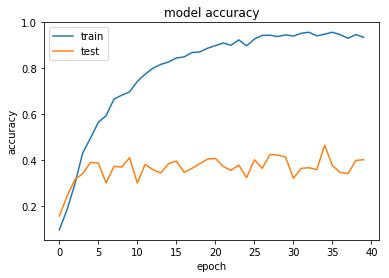

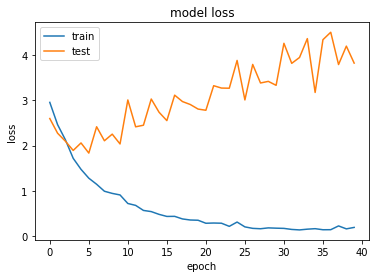

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Code to save the model somewhere in colab.  
For me, I saved it directly into my google drive. I suggest you add your own custom name inorder to distinguish between them.


In [0]:
model_final.save('gdrive/My Drive/DSTA/saved_model.h5')

# Final thoughts and improvements


Additional stuff you can do.  


1.   Plot the confusion matrix to see what classes are being classified wrongly more often
2.   Try out different learning rates and compare them. (I'll leave that up to you)

Code for plotting the confusion matrix is below.  

The first block is for loading the model, the second block is the function used to plot the matrix and the last block is the code used to get the data to plot and to plot the matrix.  

Things to note:

*  The model you are using to predict and get a confusion matrix out of has to be loaded in the variable model, look at the first block of code for an example.
*  target_names has to be changed according to your dataset
*  Size of the confusion matrix can be set using the figsize parameter in plt.figure
*  In the ImageDataGenerator for the val_generator, the parameter shuffle has to False (I have included the code in the third block to reset the val_generator)
*  To set up the predictions properly, do take a look at the parameters passed to the predict_generator method in keras
* You can choose to normalise your results in the confusion matrix with the parameter, normalise = True (default is False)
* You can change how many images, batch size and steps is used to plot the confusion matrix on
* Be careful of the location of directories used
* You can change alot of stuff, so be careful and try and understand the code. If all else fails, look for the documentation of each method/module used. Check what their outputs are, what parameters they require and what inputs they require.

There is not much else I can say in this section as I did not really experiment with the paramters much and I do not fully understand how the methods work while at the same time, writing out what I do understand and commenting it is too much work for me.  

Therefore I can only leave it to you and your googling skills to solve any problems you encounter.


---

<br>


**Lastly I want to say thank you taking the time to read through this code I haphazardly put together trying to teach myself deep learning and its libraries.(keras)**

I had no prior experience to keras or tensorflow before the compeition and some of the way I did things here may not always be the best. However through this expereience of writing this notebook, I had learnt so much about deep learning and how to utilise power libraries such as keras to make a deep learning model.  

I sincerly hope that if were like me and are just starting out to learn deep learning, this notebook has been useful for you to kick start your journey to generating a deep learning model for whatever you are doing.  

If you want to see what my team in the end for the competition or my experiement with object detection, you can check out their respectives notebooks.

In [0]:
from keras.models import load_model

# change your model path accordingly
model_path = 'train_model.hdf5'
model = load_model(model_path)

In [0]:
# function used to plot confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Preparing new generator of validation dataset for plotting confusion matrix. 

Found 347 images belonging to 15 classes.
Accuracy
0.41786743515850144 

Classification Report
              precision    recall  f1-score   support

   ChairPose       0.37      0.70      0.48        23
   ChestBump       0.79      0.65      0.71        17
   ChildPose       1.00      0.32      0.48        22
     Dabbing       0.41      0.61      0.49        23
   EaglePose       0.50      0.30      0.37        27
     HandGun       0.27      0.12      0.16        26
   HandShake       0.55      0.57      0.56        21
   HighKneel       0.42      0.92      0.58        24
   HulkSmash       0.33      0.17      0.22        24
 KoreanHeart       0.82      0.41      0.55        22
 KungfuCrane       0.19      0.19      0.19        21
KungfuSalute       0.35      0.44      0.39        25
      Salute       0.40      0.58      0.47        24
   Spiderman       0.17      0.12      0.14        26
 WarriorPose   

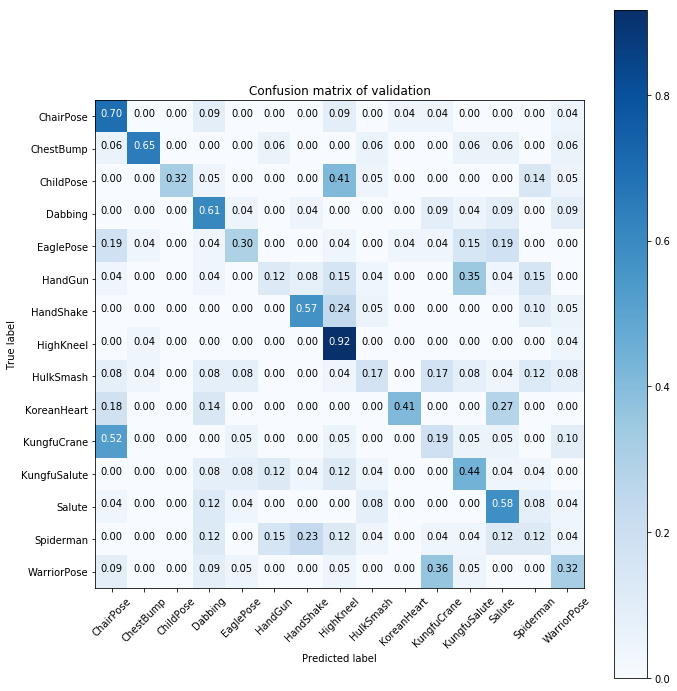

In [0]:
# Flow validation images in batches of 32 using val_datagen generator
print("Preparing new generator of validation dataset for plotting confusion matrix.", '\n')
val_generator = val_datagen.flow_from_directory(
    directory= val_folder, 
    target_size=image_size,
    batch_size=bs,
    class_mode=None,
    shuffle=False)

Y_pred = model.predict_generator(val_generator, val_generator.samples // val_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Accuracy')
print(accuracy_score(val_generator.classes, y_pred), '\n')
print('Classification Report')
target_names = ['ChairPose', 'ChestBump', 'ChildPose', 'Dabbing', 'EaglePose', 'HandGun', 'HandShake', 'HighKneel', 'HulkSmash', 'KoreanHeart', 'KungfuCrane', 'KungfuSalute', 'Salute', 'Spiderman', 'WarriorPose']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))


# Compute confusion matrix
cnf_matrix = confusion_matrix(val_generator.classes, y_pred)
np.set_printoptions(precision=1)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix of validation', normalize=True)
